# 002. Photoluminescence and Absorption Spectra of Triplet Transitions in the Nitrogen-Vacancy Center in Diamond via the One-Dimensional Configurational Coordinate Diagram

In this notebook, we demonstrate how to use `PyPL` to compute vibrationally resolved photoluminescence (PL) and absorption spectra associated with the transition between the triplet excited state ($^3E$) and the triplet ground state ($^3A_2$) of the negatively charged nitrogen-vacancy center $\text{NV}^-$ in diamond, using the one-dimenional configurational coordinate diagram (1D-CCD) approach.

The notebook is organized into two main parts:

1. Construction of the one-dimensional configurational coordinate diagram

2. Computation of photoluminescence and absorption spectra

## 1. Construction of the one-dimensional configurational coordinate diagram

In [1]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from pypl.config_coord_1d_solver import config_coord_1d_solver
from pypl.utils import *
import os

path = os.getcwd()
os.chdir(path)

The first step is to construct the one-dimensional configurational coordinate and extract the mass-weighted displacements and effective phonon frequencies.

Starting from the equilibrium geometries of the ground state ${}^3\!A_2$ (`002_nv_diamond_1d_ccd/gs_dft/gs_coord.in`) and the excited state ${}^3\!E$ (`002_nv_diamond_1d_ccd/es_cdft/es_cdft_010_coord.in`), we perform a linear interpolation between them and compute the energy profiles of both states along the interpolated path.

Ground-state DFT calculations for the interpolated configurations are provided in `002_nv_diamond_1d_ccd/gs_1d_ccd/`, where the script `generate.py` generates single-point DFT inputs for each interpolated geometry. Similarly, the excited-state constrained-occupation DFT calculations are found in `002_nv_diamond_1d_ccd/es_1d_ccd/`. The interpolation path is defined as `np.linspace(-0.2, 1.2, 15)`, where `0.0` corresponds to the equilibrium ground-state geometry and `1.0` to the equilibrium excited-state geometry.

Note: The atomic ordering must be identical in the ground-state DFT and excited-state constrained-occupation calculations to ensure correct interpolation.

First, we compute the mass-weighted atomic displacement between the ground-state and excited-state geometries.

In [2]:
# Unit of coordinates and cell_parameters is Angstrom
atomic_symbols, gs_coord, cell_parameters = parse_atoms_qexml('002_nv_diamond_1d_ccd/gs_dft/pwscf.xml')
atomic_symbols_2, es_coord, cell_parameters_2 = parse_atoms_qexml('002_nv_diamond_1d_ccd/es_cdft/pwscf.xml')

# Ensure that both sets of atomic coordinates have consistent atomic symbols and cell parameters.
assert atomic_symbols == atomic_symbols_2, "Mismatch in atomic symbols between ground-state and excited-state structures."
assert np.max(np.abs(cell_parameters - cell_parameters_2)) < 1e-12, "Mismatch in cell parameters between ground-state and excited-state structures."

In [3]:
mass_list = {'C': 12.0107, 'N': 14.0067}
all_masses = np.array([mass_list[sym] for sym in atomic_symbols])

In [4]:
delta_q = np.linalg.norm((es_coord - gs_coord) * all_masses[:, None]**0.5)
print('\Delta Q = % .10e amu^{0.5} \AA' % (delta_q))

\Delta Q =  6.9573191451e-01 amu^{0.5} \AA


This displacement ($\Delta Q$) is comparable to the value obtained from the Huang–Rhys theory using all phonon modes in *Tutorial 001*, which is approximately $0.65\ \text{amu}^{0.5} \text{Å}$.

In the next step, we parse the energies from the single-point DFT and CDFT calculations at each interpolated geometry.

In [5]:
import os

relative_coordinates = np.linspace(-0.2, 1.2, 15)

gs_rel_coord = []
es_rel_coord = []
# energies are in eV
gs_energies = np.zeros(relative_coordinates.shape[0])
es_energies = np.zeros(relative_coordinates.shape[0])

for i in range(relative_coordinates.shape[0]):
    fileName = '002_nv_diamond_1d_ccd/gs_1d_ccd/Image-%d/pwscf.xml' % (i + 1)
    if os.path.exists(fileName):
        gs_rel_coord.append(i)
        gs_energies[i] = parse_total_energy_qexml(fileName)
    fileName = '002_nv_diamond_1d_ccd/es_1d_ccd/Image-%d/pwscf.xml' % (i + 1)
    if os.path.exists(fileName):
        es_rel_coord.append(i)
        es_energies[i] = parse_total_energy_qexml(fileName)

# reset the energy zero
ref_energy = np.min(gs_energies)
gs_energies = gs_energies[gs_rel_coord] - np.min(ref_energy)
es_energies = es_energies[es_rel_coord] - np.min(ref_energy)

gs_1d_coord = delta_q * relative_coordinates[gs_rel_coord]
es_1d_coord = delta_q * relative_coordinates[es_rel_coord]

# print(gs_1d_coord)
# print(gs_energies)

# print(es_1d_coord)
# print(es_energies)

We can now plot the 1D CCD and perform a fit to obtain the effective phonon frequencies. The fitting is performed using the points in the vicinity of the local minima on both energy surfaces.

In [6]:
from scipy.optimize import curve_fit

def gs_fit_fun(x, a, c):
    return a * x**2 + c


def es_fit_fun(x, a, c):
    return a * (x - delta_q) ** 2 + c

# Ground state phonon
gs_params = curve_fit(gs_fit_fun, gs_1d_coord[:5], gs_energies[:5])[0]
print("Parameters for GS curve: ", gs_params)
gs_fit_energies = gs_fit_fun(gs_1d_coord, gs_params[0], gs_params[1])

# (rad / s)^2
gs_phonon = 2 * gs_params[0] * constants.eV / (1e-10**2 * constants.physical_constants['atomic mass constant'][0])
# eV^2
gs_phonon *= (constants.hbar**2 / constants.eV**2)
# meV
gs_phonon = np.sqrt(gs_phonon) * 1000
print("GS phonon is %.5f meV" % gs_phonon)

# Excited state phonon
es_params = curve_fit(es_fit_fun, es_1d_coord[4:], es_energies[4:])[0]
print("Parameetrs for ES curve: ", es_params)
es_fit_energies = es_fit_fun(es_1d_coord, es_params[0], es_params[1])

# (rad / s)^2
es_phonon = 2 * es_params[0] * constants.eV / (1e-10**2 * constants.physical_constants['atomic mass constant'][0])
# eV^2
es_phonon *= (constants.hbar**2 / constants.eV**2)
# meV
es_phonon = np.sqrt(es_phonon) * 1000
print("ES phonon is %.5f meV" % es_phonon)


Parameters for GS curve:  [ 4.17627359e-01 -1.34422862e-05]
GS phonon is 59.08890 meV
Parameetrs for ES curve:  [0.49472065 1.70587686]
ES phonon is 64.31191 meV


In [7]:
gs_hrf = (
    delta_q**2 * 1e-10**2 * constants.physical_constants['atomic mass constant'][0]
    * gs_phonon * 1e-3 * constants.eV / constants.hbar
    / (2 * constants.hbar)
)
print("HR for GS is %.5f" % gs_hrf)

es_hrf = (
    delta_q**2 * 1e-10**2 * constants.physical_constants['atomic mass constant'][0]
    * es_phonon * 1e-3 * constants.eV / constants.hbar
    / (2 * constants.hbar)
)
print("HR for ES is %.5f" % es_hrf)

HR for GS is 3.42111
HR for ES is 3.72351


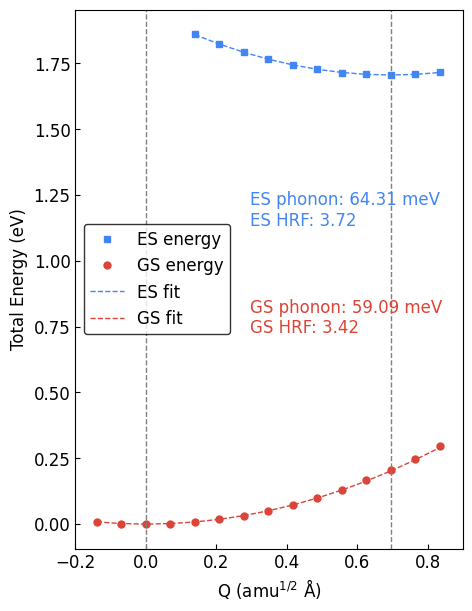

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7))

blue = "#4285F4"
red = "#DB4437"

ax.plot(es_1d_coord, es_energies, color=blue, linestyle="", marker="s", markersize=5, label="ES energy")
ax.plot(gs_1d_coord, gs_energies, color=red, linestyle="", marker="o", markersize=5, label="GS energy")

ax.plot(es_1d_coord, es_fit_energies, color=blue, linestyle="--", linewidth=1.0, marker="", label="ES fit")
ax.plot(gs_1d_coord, gs_fit_energies, color=red, linestyle="--", linewidth=1.0, marker="", label="GS fit")

ax.text(x=0.45, y=0.4, s="GS phonon: %.2f meV\nGS HRF: %.2f" % (gs_phonon, gs_hrf), color=red, transform=ax.transAxes)
ax.text(x=0.45, y=0.6, s="ES phonon: %.2f meV\nES HRF: %.2f" % (es_phonon, es_hrf), color=blue, transform=ax.transAxes)

ax.axvline(x=0.0, color="gray", linestyle="--", linewidth=1)
ax.axvline(x=delta_q, color="gray", linestyle="--", linewidth=1)

ax.legend(fontsize=12, loc="center left", edgecolor="black")
ax.set_xlim((-0.2, 0.9))
plt.xlabel("Q (amu$^{1/2}$ Å)")
plt.ylabel("Total Energy (eV)")
plt.tick_params(direction="in")

plt.show()

Therefore, we obtain an effective phonon energy of $59.09$ meV for the ground state and $64.31$ meV for the excited state.

## 2. Computation of photoluminescence and absorption spectra

With the mass-weighted atomic displacement (`delta_q`) and the effective phonon energies of the ground and excited states (`gs_phonon` and `es_phonon`), we can use the `config_coord_1d_solver` from `PyPL` to compute both the PL and absorption spectra.

There are a few parameters that need to be defined.

In [9]:
# order
order_es = 50
order_gs = 60

# energy range for plot
ene_range = [-200, 1200]

# resolution
resol = 1401

# temperature: K
temp = 5

# broadening
gamma = 0.3
sigma = [8, 25]

# ZPL: meV
ezpl = 1945

The PL spectrum is obtained by first evaluating the Franck–Condon integrals, followed by summing over all possible initial and final vibrational states.

In [10]:
ccd_pl = config_coord_1d_solver(es_phonon, gs_phonon, delta_q)

ccd_pl.compute_franck_condon_integrals(ni=order_es, nf=order_gs)
ccd_pl.bulid_fc_lsp(eneaxis=np.linspace(ene_range[0], ene_range[1], resol),
                    temp=temp, sigma=sigma, zpl_lorentzian=True, gamma=gamma)
pl_spectrum = ccd_pl.compute_spectrum(tdm=1.0, zpl=ezpl, spectrum_type='PL')

Integral check: 1.0100972996226196


The absorption spectrum is evaluated in the same manner, with the important distinction that the initial state corresponds to the ground state and the final state to the excited state, i.e., the opposite of the PL process.

In [11]:
ccd_abs = config_coord_1d_solver(gs_phonon, es_phonon, delta_q)

ccd_abs.compute_franck_condon_integrals(ni=order_gs, nf=order_es)
ccd_abs.bulid_fc_lsp(eneaxis=np.linspace(ene_range[0], ene_range[1], resol),
                        temp=temp, sigma=sigma, zpl_lorentzian=True, gamma=gamma)

abs_spectrum = ccd_abs.compute_spectrum(tdm=1.0, zpl=ezpl, spectrum_type='Abs')

Integral check: 1.0100958192278924


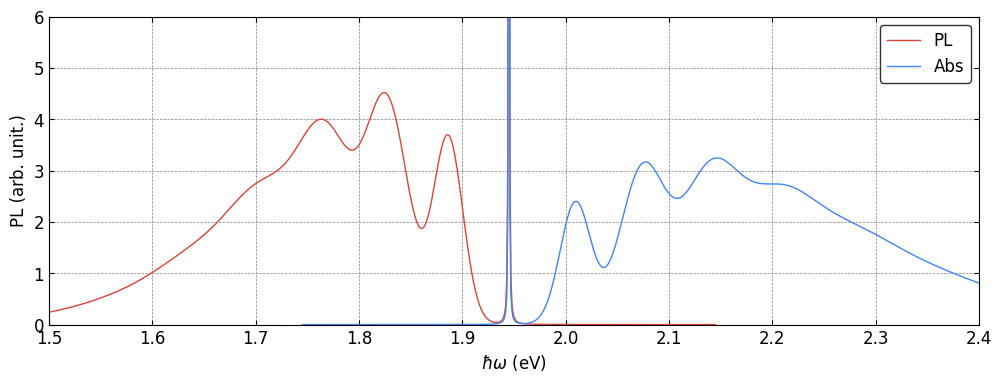

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

red = "#DB4437"
blue = "#4285F4"

ax.plot(pl_spectrum[0] * 1e-3, pl_spectrum[1] / (np.sum(pl_spectrum[1]) * abs(pl_spectrum[0][1] - pl_spectrum[0][0])) * 1e3,
        color=red, linewidth=1, linestyle="-", label='PL')
ax.plot(abs_spectrum[0] * 1e-3, abs_spectrum[1] / (np.sum(abs_spectrum[1]) * abs(abs_spectrum[0][1] - abs_spectrum[0][0])) * 1e3,
        color=blue, linewidth=1, linestyle="-", label='Abs')

ax.set_xlim((1.5, 2.4))
ax.set_ylim((0.0, 6))

ax.legend(fontsize=12, loc="upper right", edgecolor="black")
ax.grid(color='gray', linestyle='--', linewidth=0.5)

ax.tick_params(direction="in")
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.set_xlabel("$\hbar\omega$ (eV)")
ax.set_ylabel("PL (arb. unit.)")

plt.show()

These spectra can be further compared with the results obtained from the Huang–Rhys theory including all phonon modes, as demonstrated in Tutorial 001.

In [13]:
from pypl.hr_solver import hr_solver

gs_phonon_file = '001_nv_diamond_abs_pl/phonopy_files/gs_ph_mesh.hdf5'
gs_file = '001_nv_diamond_abs_pl/gs_dft/pwscf.xml'
es_file = '001_nv_diamond_abs_pl/es_cdft/pwscf.xml'

# Unit of freqs is THz
gs_phonon_freqs, gs_phonon_modes = parse_phonopy_h5(gs_phonon_file)
# Unit of coordinates and cell_parameters is Angstrom
atomic_symbols, gs_coord, cell_parameters = parse_atoms_qexml(gs_file)
atomic_symbols_2, es_coord, cell_parameters_2 = parse_atoms_qexml(es_file)

mass_list = {'C': 12.0107, 'N': 14.0067}

pl_use_dis = hr_solver()
hrf_dict_pl_dis = pl_use_dis.compute_hrf_dis(gs_phonon_freqs, gs_phonon_modes, atomic_symbols, gs_coord, es_coord, cell_parameters, mass_list=mass_list)
linshape_fft_pl_dis = pl_use_dis.compute_lineshape_fft(hrf_dict_pl_dis, temp=4, sigma=[6, 2], zpl_broadening=0.3)
spectrum_pl_dis = pl_use_dis.compute_spectrum(ezpl, spectrum_type='PL', lineshape=linshape_fft_pl_dis)


es_phonon_fname = '001_nv_diamond_abs_pl/phonopy_files/es_ph_mesh.hdf5'
es_phonon_freqs, es_phonon_modes = parse_phonopy_h5(es_phonon_fname)

abs_use_dis = hr_solver()
hrf_dict_abs_dis = abs_use_dis.compute_hrf_dis(es_phonon_freqs, es_phonon_modes, atomic_symbols, gs_coord, es_coord, cell_parameters, mass_list=mass_list)
lineshape_fft_abs_dis = abs_use_dis.compute_lineshape_fft(hrf_dict_abs_dis, temp=4, sigma=[6.0, 2.0], zpl_broadening=0.3)
spectrum_abs_dis = abs_use_dis.compute_spectrum(ezpl, spectrum_type='Abs', lineshape=lineshape_fft_abs_dis)

Computing Huang-Rhys factors using atomic displacements.
Total \Delta Q is  6.529832366847e-01 amu^{0.5} \AA
Total Huang-Rhys factor is  2.985289195896e+00
time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.999999999865
Computing Huang-Rhys factors using atomic displacements.
Total \Delta Q is  6.529832366847e-01 amu^{0.5} \AA
Total Huang-Rhys factor is  3.102826958964e+00
time_axis range: -2.067833848461893e-12 to 2.067833848461893e-12
d_t (s): 2.066800448237774e-15
Energy range (meV): -1000.0000000000176 to 1000.0000000000176
d_E (meV): 0.9999999999998863
Integral check: 999.9999999998641


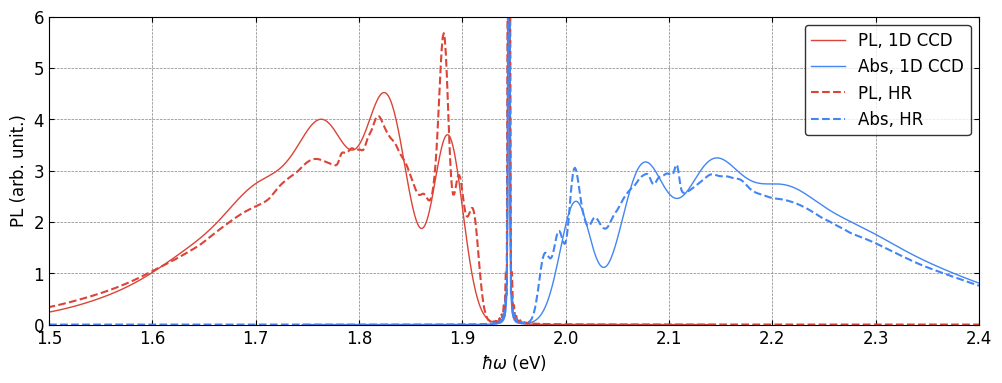

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

red = "#DB4437"
blue = "#4285F4"

ax.plot(pl_spectrum[0] * 1e-3, pl_spectrum[1] / (np.sum(pl_spectrum[1]) * abs(pl_spectrum[0][1] - pl_spectrum[0][0])) * 1e3,
        color=red, linewidth=1, linestyle="-", label='PL, 1D CCD')
ax.plot(abs_spectrum[0] * 1e-3, abs_spectrum[1] / (np.sum(abs_spectrum[1]) * abs(abs_spectrum[0][1] - abs_spectrum[0][0])) * 1e3,
        color=blue, linewidth=1, linestyle="-", label='Abs, 1D CCD')

ax.plot(spectrum_pl_dis[0] * 1e-3, spectrum_pl_dis[1] / (np.sum(spectrum_pl_dis[1]) * abs(spectrum_pl_dis[0][1] - spectrum_pl_dis[0][0])) * 1e3,
        label='PL, HR', color=red, linestyle='--')
ax.plot(spectrum_abs_dis[0] * 1e-3, spectrum_abs_dis[1] / (np.sum(spectrum_abs_dis[1]) * abs(spectrum_abs_dis[0][1] - spectrum_abs_dis[0][0])) * 1e3,
        label='Abs, HR', color=blue, linestyle='--')

ax.set_xlim((1.5, 2.4))
ax.set_ylim((0.0, 6))

ax.legend(fontsize=12, loc="upper right", edgecolor="black")
ax.grid(color='gray', linestyle='--', linewidth=0.5)

ax.tick_params(direction="in")
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.set_xlabel("$\hbar\omega$ (eV)")
ax.set_ylabel("PL (arb. unit.)")

plt.show()

The 1D CCD approach shows generally good agreement with the results from Huang–Rhys theory, although it misses some of the finer spectral features. Nevertheless, the 1D CCD provides a powerful and practical approximation.